In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
from __future__ import print_function, division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
#hyperparams

num_epochs = 10
total_series_length = 50000
truncated_backprop_length = 15
state_size = 4
num_classes = 2
echo_step = 3
batch_size = 5
num_batches = total_series_length//batch_size//truncated_backprop_length

In [3]:
#Step 1 - Collect data
#Now generate the training data, 
#the input is basically a random binary vector. The output will be the 
#“echo” of the input, shifted echo_step steps to the right.

#Notice the reshaping of the data into a matrix with batch_size rows. 
#Neural networks are trained by approximating the gradient of loss function 
#with respect to the neuron-weights, by looking at only a small subset of the data, 
#also known as a mini-batch.The reshaping takes the whole dataset and puts it into 
#a matrix, that later will be sliced up into these mini-batches.

def generateData():
    #0,1, 50K samples, 50% chance each chosen
    x = np.array(np.random.choice(2, total_series_length, p=[0.5, 0.5]))
    #shift 3 steps to the left
    y = np.roll(x, echo_step)
    #padd beginning 3 values with 0
    y[0:echo_step] = 0
    #Gives a new shape to an array without changing its data.
    #The reshaping takes the whole dataset and puts it into a matrix, 
    #that later will be sliced up into these mini-batches.
    x = x.reshape((batch_size, -1))  # The first index changing slowest, subseries as rows
    y = y.reshape((batch_size, -1))

    return (x, y)

data= generateData()


In [4]:
#datatype, shape (5, 15) 2D array or matrix, batch size shape for later
batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])

#and one for the RNN state, 5,4 
init_state = tf.placeholder(tf.float32, [batch_size, state_size])


In [5]:
#randomly initialize weights
W = tf.Variable(np.random.rand(state_size+1, state_size), dtype=tf.float32)
#anchor, improves convergance, matrix of 0s 
b = tf.Variable(np.zeros((1,state_size)), dtype=tf.float32)

W2 = tf.Variable(np.random.rand(state_size, num_classes),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float32)

In [6]:
# Unpack columns
#Unpacks the given dimension of a rank-R tensor into rank-(R-1) tensors.
#so a bunch of arrays, 1 batch per time step
inputs_series = tf.unstack(batchX_placeholder, axis=1)
labels_series = tf.unstack(batchY_placeholder, axis=1)

In [7]:
#Forward pass
#state placeholder
current_state = init_state
#series of states through time
states_series = []
#for each set of inputs
#forward pass through the network to get new state value
#store all states in memory
for current_input in inputs_series:
    #format input
    current_input = tf.reshape(current_input, [batch_size, 1])
    #mix both state and input data 
    input_and_state_concatenated = tf.concat([current_input, current_state],1)  # Increasing number of columns
    #perform matrix multiplication between weights and input, add bias
    #squash with a nonlinearity, for probabiolity value
    next_state = tf.tanh(tf.matmul(input_and_state_concatenated, W) + b)  # Broadcasted addition
    #store the state in memory
    states_series.append(next_state)
    #set current state to next one
    current_state = next_state
    #print('here')


In [8]:
#calculate loss
#second part of forward pass
#logits short for logistic transform
logits_series = [tf.matmul(state, W2) + b2 for state in states_series] #Broadcasted addition
#apply softmax nonlinearity for output probability
predictions_series = [tf.nn.softmax(logits) for logits in logits_series]
losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels) for logits, labels in zip(logits_series,labels_series)]
#computes average, one value
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)
#print('Here')


In [9]:
#visualizer
def plot(loss_list, predictions_series, batchX, batchY):
    plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)

    for batch_series_idx in range(5):
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])

        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_length, 0, 2])
        left_offset = range(truncated_backprop_length)
        plt.bar(left_offset, batchX[batch_series_idx, :], width=1, color="blue")
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")

    plt.draw()
    plt.pause(0.0001)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


New data, epoch 0
New data, epoch 1
New data, epoch 2
New data, epoch 3
New data, epoch 4
New data, epoch 5
New data, epoch 6
New data, epoch 7
New data, epoch 8
New data, epoch 9


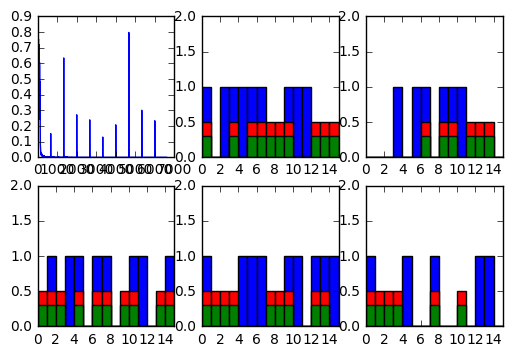

In [10]:
#Step 3 Training the network
with tf.Session() as sess:
    #we stupidly have to do this everytime, it should just know
    #that we initialized these vars. v2 guys, v2..
    sess.run(tf.initialize_all_variables())
    #interactive mode
    plt.ion()
    #initialize the figure
    plt.figure()
    #show the graph
    plt.show()
    #to show the loss decrease
    loss_list = []

    for epoch_idx in range(num_epochs):
        #generate data at eveery epoch, batches run in epochs
        x,y = generateData()
        #initialize an empty hidden state
        _current_state = np.zeros((batch_size, state_size))

        print("New data, epoch", epoch_idx)
        #each batch
        for batch_idx in range(num_batches):
            #starting and ending point per batch
            #since weights reoccuer at every layer through time
            #These layers will not be unrolled to the beginning of time, 
            #that would be too computationally expensive, and are therefore truncated 
            #at a limited number of time-steps
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length

            batchX = x[:,start_idx:end_idx]
            batchY = y[:,start_idx:end_idx]
            
            #run the computation graph, give it the values
            #we calculated earlier
            _total_loss, _train_step, _current_state, _predictions_series, _W2, _W1 = sess.run(
                [total_loss, train_step, current_state, predictions_series, W2, W],
                feed_dict={
                    batchX_placeholder:batchX,
                    batchY_placeholder:batchY,
                    init_state:_current_state
                })

            loss_list.append(_total_loss)

            if batch_idx%100 == 0:
                #print("Step",batch_idx, "Loss", _total_loss)
                plot(loss_list, _predictions_series, batchX, batchY)

plt.ioff()
plt.show()

In [84]:
print("W1 = ", _W1)
print("W2 = ", _W2)

W1 =  [[ 1.05162835 -0.00635728  0.87784564 -0.15264903]
 [-0.2622093   0.3567926   0.41994363  2.26974392]
 [-1.56516457  1.2242744   2.14454103  0.30306277]
 [ 0.56706262 -0.4771069  -0.76488531  1.83766377]
 [ 0.28072128  0.79510319 -0.18230765 -0.3887125 ]]
W2 =  [[ 3.27130675 -2.01657677]
 [-1.7482357   2.45327783]
 [-3.17053151  3.66590047]
 [ 0.22835805  0.81029153]]


In [85]:
_total_loss

0.00019736402

In [86]:
W1 =  [[  1.16491103e+00   5.35046570e-02   1.13307178e+00  -2.23877095e-03]
 [ -6.56468332e-01   1.65468669e+00   8.27385306e-01   2.62128115e+00]
 [ -7.64668524e-01   1.71116114e+00   9.39779699e-01   9.67804790e-01]
 [  7.83081949e-01  -1.88786900e+00  -9.57958639e-01   1.42621481e+00]
 [  5.53146601e-01   5.93811095e-01  -4.33015585e-01  -1.08429164e-01]]
W2 =  [[ 2.6343441  -1.37960315]
 [-3.46717691  4.17220306]
 [-1.93619549  2.43156648]
 [ 0.32730255  0.7113471 ]]

SyntaxError: invalid syntax (<ipython-input-86-850dafb0beed>, line 1)